<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
df = pd.read_csv('/datasets/taxi.csv')

In [3]:
def info_data(data):
    display(data.head())
    print('')
    display(data.info())
    print('')
    display(data.describe().T)
    print('')
    print('___________')
    print('Кол-во пропусков:\n', data.isna().sum())
    print('___________')
    print('Кол-во явных дубликатов:', data.duplicated().sum())
    print('___________')

### Вывод

Сделаны импорты, данные загружены, написана функция для анализа

## Анализ

In [4]:
info_data(df)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0



___________
Кол-во пропусков:
 datetime      0
num_orders    0
dtype: int64
___________
Кол-во явных дубликатов: 0
___________


Пропусков и дубликатов нет

In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [7]:
df.set_index('datetime', inplace=True)

In [8]:
df = df.resample('1H').sum()

По заказу бизнеса нужнен промежуток в 1 час

In [9]:
df.index.is_unique

True

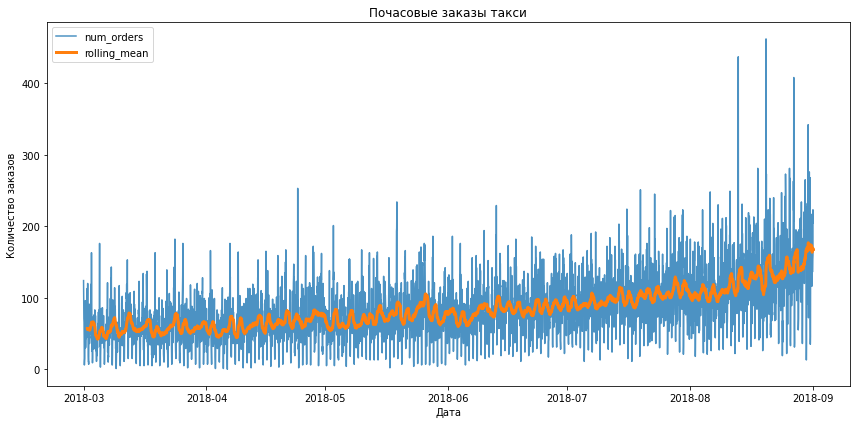

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['num_orders'], label='num_orders',  alpha=0.8)
plt.plot(df.index, df['num_orders'].rolling(24).mean(), label='rolling_mean', linewidth=3)
plt.title ('Почасовые заказы такси')
plt.xlabel('Дата');  plt.ylabel('Количество заказов')
plt.legend();  plt.tight_layout();  plt.show()


Спрос растёт на протяжении всего периода и к августу-сентябрю становится почти вдвое выше мартовского, при этом амплитуда всплесков заметно расширяется.

In [11]:
series = df['num_orders']           

stl = STL(series, period=24, robust=True)  
res = stl.fit()
seasonal = res.seasonal

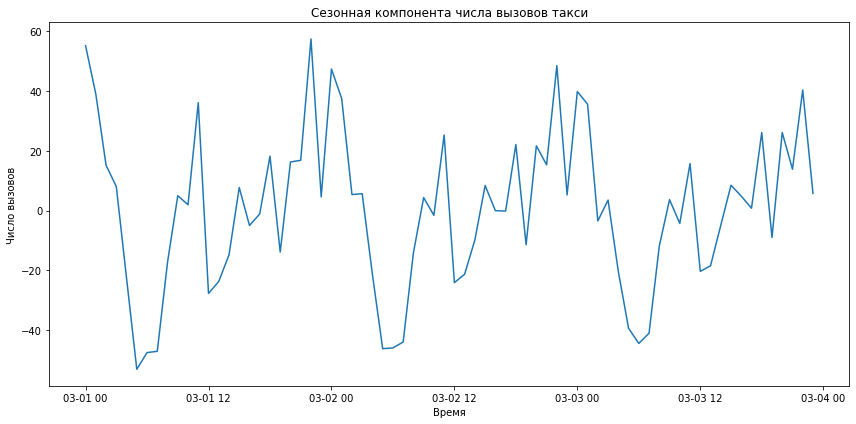

In [12]:
seasonal_first3 = seasonal.iloc[:72]

plt.figure(figsize=(12,6))
plt.plot(seasonal_first3.index, seasonal_first3)
plt.title('Сезонная компонента числа вызовов такси')
plt.xlabel('Время')
plt.ylabel('Число вызовов')
plt.tight_layout()
plt.show()


Амплитуда колебаний держится примерно одинаковой три дня подряд, что подтверждает устойчивый 24-часовой паттерн спроса. 

Чтобы правильно подобрать количество лагов, построим график коэффициентов автокорреляции:

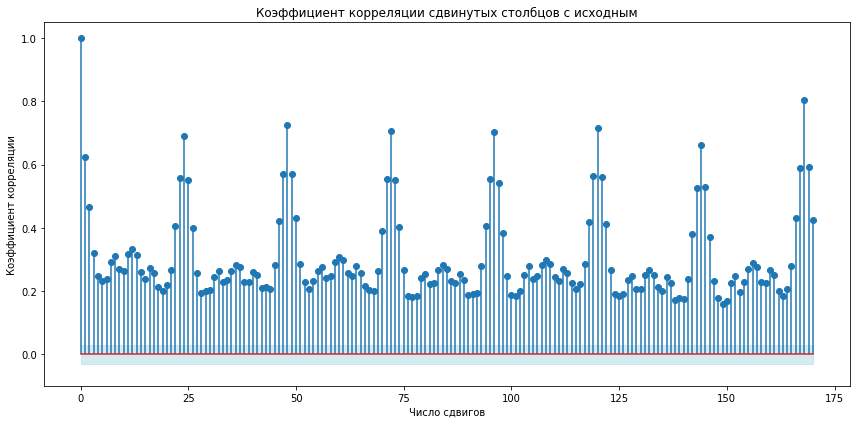

In [13]:
max_lag = 170
corrs = [series.corr(series.shift(lag)) 
         for lag in range(max_lag + 1)]


plt.figure(figsize=(12,6))
plt.stem(range(max_lag + 1), corrs, use_line_collection=True)
conf = 1.96 / np.sqrt(len(series))          
plt.fill_between(range(max_lag + 1), -conf, conf, 
                 color='lightblue', alpha=0.5)

plt.title('Коэффициент корреляции сдвинутых столбцов с исходным')
plt.xlabel('Число сдвигов')
plt.ylabel('Коэффициент корреляции')
plt.ylim(-0.1, 1.05)
plt.tight_layout()
plt.show()


На графике, чётко просматривается пик на лаге 168 ч — это явное подтверждение недельной сезонности. Выберем лаги 24 и 168

### Вывод

Исходный датасет содержит 26 496 строк с двумя полями — отметка времени и количество заказов. Дата приведена к datetime64, после чего ряд агрегирован до часового шага, как требует бизнес-задача 

С марта по август 2018-го средний спрос вырос почти вдвое: скользящее среднее (окно 24 ч) поднимается с ≈60 до ≈120 заказов/час 

Виден устойчивая суточная сезонность, а также прослеживается устойчивая недельная сезонность.Будет выбран lag_168, чтобы не терять эту регулярность

Амплитуда колебаний растёт вместе с трендом единичные выбросы (> 400 заказов/ч)

## Обучение

### Подготовка признаков

Добавим столбцы с признаками

Так как мы обнаружили сезонность внутри суток и сезонность внутри недели создадим два столбца с признаками: часы и день недели

In [14]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

df.head()

,num_orders,hour,dayofweek
datetime,,,
2018-03-01 00:00:00,124,0,3
2018-03-01 01:00:00,85,1,3
2018-03-01 02:00:00,71,2,3
2018-03-01 03:00:00,66,3,3
2018-03-01 04:00:00,43,4,3


Функция lags() добавляет к ряду выбранные «ключевые» лаги (по умолчанию 24 ч и 168 ч) + скользящее среднее за сутки. Ниже формируем два набора признаков:  df_24  – только lag_24, df_168 – только lag_168. Сравним, как разные «точки памяти» влияют на качество модели.

In [15]:
def lags(series, lags=(24, 168), roll_window=24):
    df = pd.DataFrame({'num_orders': series})

    for l in lags:
        df[f'lag_{l}'] = series.shift(l)

    df[f'roll_mean_{roll_window}'] = (series.shift(1).rolling(roll_window).mean())

    return df.dropna()


series = df['num_orders']      


df_24  = lags(series, lags=[24])     
df_168 = lags(series, lags=[168])

df_168.head()
df_24.head()

,num_orders,lag_24,roll_mean_24
datetime,,,
2018-03-02 00:00:00,90,124.0,56.833333
2018-03-02 01:00:00,120,85.0,55.416667
2018-03-02 02:00:00,75,71.0,56.875000
2018-03-02 03:00:00,64,66.0,57.041667
2018-03-02 04:00:00,20,43.0,56.958333


Сделаем функцию model_adjuster: ей отдаём модель и сетку гиперпараметров, а внутри она берёт каждый из трёх датасетов, выделяет тренировочную часть, гоняет TimeSeriesSplit, подбирает лучшие настройки и складывает их в списки. В финале эти списки превращаем в аккуратную таблицу-сводку с лейблом модели, числом лагов и её RMSE.









In [27]:
name_list = []
rmse_list = []
lags_list = []

def model_adjuster(model, params, name, scale_numeric=False):
    rscv = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        scoring='neg_root_mean_squared_error',
        cv=TimeSeriesSplit(),
        random_state=12345)       

    for lag, df in [(24, df_24), (168, df_168)]:
        train, test = train_test_split(df.dropna(), shuffle=False, test_size=0.1)

        X_train = train.drop(columns='num_orders')
        y_train = train['num_orders']

        if scale_numeric:
            scaler = StandardScaler()
            X_train = pd.DataFrame(
                scaler.fit_transform(X_train),
                index=X_train.index,
                columns=X_train.columns
            )

        best = rscv.fit(X_train, y_train)
        rmse = -best.best_score_

        print(f'lag={lag} | RMSE={rmse:.2f} | params={best.best_params_}')
        name_list.append(name)
        rmse_list.append(rmse)
        lags_list.append(lag)

  

Используем четыре модели: линейная регресия, случайный лес, градиентный бустинг и Catboost

In [41]:
print('Линейная регрессия \n')
model_adjuster(LinearRegression(), {}, 'Линейная регрессия', scale_numeric=True)

Линейная регрессия 

lag=24 | RMSE=29.25 | params={}
lag=168 | RMSE=24.59 | params={}


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [29]:
print('Случайный лес \n')
model = RandomForestRegressor(random_state=12345) 
params={'max_depth':range(1,21), 
        'n_estimators':range(1,21)} 
model_adjuster(model, params, 'Случайный лес') 

Случайный лес 

lag=24 | RMSE=29.61 | params={'n_estimators': 11, 'max_depth': 6}
lag=168 | RMSE=25.17 | params={'n_estimators': 11, 'max_depth': 6}


In [30]:
print('Градиентный бустинг\n')
model = GradientBoostingRegressor(random_state=12345)
params = {
    'n_estimators': [300, 400, 500],
    'max_depth'   : [3, 5],
    'learning_rate': [0.05, 0.1]} 
model_adjuster(model, params, 'Градиентный бустинг')

Градиентный бустинг

lag=24 | RMSE=31.48 | params={'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05}
lag=168 | RMSE=26.15 | params={'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05}


In [31]:
print('CatBoost \n')
model = CatBoostRegressor(random_state = 12345, verbose=False) 
params = {'depth':range(1,6), 
          'iterations':[10, 100]} 
model_adjuster(model, params, 'CatBoost') 

CatBoost 

lag=24 | RMSE=29.16 | params={'iterations': 10, 'depth': 3}
lag=168 | RMSE=24.78 | params={'iterations': 10, 'depth': 3}


In [32]:
result = pd.DataFrame(data={'Название модели':name_list, 'Число сдвигов':lags_list, 'RMSE':rmse_list})

In [42]:
result.sort_values(by='RMSE', ascending=True)

,Название модели,Число сдвигов,RMSE
1,Линейная регрессия,168,24.590154
7,CatBoost,168,24.776044
3,Случайный лес,168,25.172122
5,Градиентный бустинг,168,26.150769
6,CatBoost,24,29.161324
0,Линейная регрессия,24,29.246191
2,Случайный лес,24,29.609016
4,Градиентный бустинг,24,31.483234


Лучший результат показала модель линейной регрессии с лагом 168 RMSE = 24.59

## Тестирование

In [34]:
model = LinearRegression() 

train, test = train_test_split(df_168, shuffle=False, test_size=0.1)
train = train.dropna()


features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

model.fit(features_train, target_train)
predictions = model.predict(features_test)

print('RMSE: ', mean_squared_error(predictions, target_test)**0.5)

RMSE:  36.251397323092434


RMSE в пределах допустимого значения

Построим предсказанный график

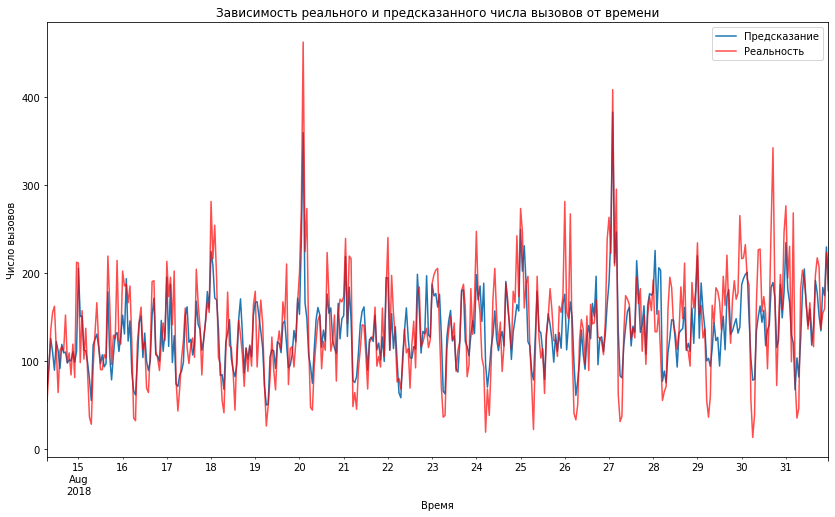

In [35]:
predictions_series = pd.Series(data=predictions, index=target_test.index)
predictions_series.plot(figsize=(14, 8), label='Предсказание', alpha=1)
target_test.plot(label='Реальность', color='red', alpha=0.7)
plt.legend()
plt.title('Зависимость реального и предсказанного числа вызовов от времени')
plt.xlabel('Время')
plt.ylabel('Число вызовов')
plt.show()

График показывает хорошее совпадение реального и предсказанного значения

In [39]:
train, test = train_test_split(df_24.dropna(), shuffle=False, test_size=0.1)

rmse_24  = mean_squared_error(test['num_orders'],
                              test['lag_24'],  squared=False)

print(f'Бейзлайн 24 ч: {rmse_24:.2f}')


train, test = train_test_split(df_168.dropna(), shuffle=False, test_size=0.1)

rmse_168 = mean_squared_error(test['num_orders'],
                              test['lag_168'], squared=False)
print(f'Бейзлайн 168 ч: {rmse_168:.2f}')


Бейзлайн 24 ч: 57.30
Бейзлайн 168 ч: 39.29


Недельный сдвиг гораздо информативнее, чем суточный. Модели объективно лучше обоих бейзлайнов.Лучшая линейная регрессия с lag-168 даёт RMSE ≈ 24,59. Базовые бейзлайны уступают результату модели примерно на 35–40 %.



## Вывод

В ходе проекта были импортированы данные о колличестве вызовов такси в определённые даты. Данные были проанализированы и был произведён ресемплинг по одному часу как и просил заказчик. 

В ходе анализа обнаружена суточная и недельная сезонность, на основе этого были выбраны параметры и лаги.

Были проанализированы несколько моделей, и выбрана модель линейной регрессии с лагом 168, которая дала наилучший результат. Метрика модели RMSE (24,59) удовлетворяет требованию заказчика (48).

Результаты работы моделей оказались намного лучше базлайнов